# Augmented Reality with Planar Homographies

In [129]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from utils import read_video, play_video

In [130]:
def get_correspondences(img, video):
    """
    Get the corresponding points from the image and the video
    params:
        img: the image
        video: list of frames from the video or a single frame
    returns:
        src_pts: the points from the image
        dst_pts: the points from the video
    """
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img, None)

    kp2 = []
    des2 = []
    
    # check if the video is a list of frames or a single frame
    if type(video) == list:
        for frame in video:
            kp, des = sift.detectAndCompute(frame, None)
            kp2.append(kp)
            des2.append(des)
    else:
        kp, des = sift.detectAndCompute(video, None)
        kp2.append(kp)
        des2.append(des)

    bf = cv.BFMatcher()
    matches = []
    for des in des2:
        matches.append(bf.knnMatch(des1, des, k=2))
    
    # Apply ratio test for each frame
    good = []
    for match in matches:
        good.append([])
        for m, n in match:
            if m.distance < 0.75 * n.distance:
                good[-1].append(m)
    
    # sort the matches based on the distance
    for i in range(len(good)):
        good[i] = sorted(good[i], key = lambda x:x.distance)
    
    src_pts = []
    dst_pts = []
    for i in range(len(good)):
        src_pts.append(np.float32([kp1[m.queryIdx].pt for m in good[i]]).reshape(-1, 1, 2))
        dst_pts.append(np.float32([kp2[i][m.trainIdx].pt for m in good[i]]).reshape(-1, 1, 2))
    
    # plot the matches for every frame
    matching_frames = []
    for i in range(len(good)):
        img3 = cv.drawMatches(img, kp1, video[i], kp2[i], good[i], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        matching_frames.append(img3)

    return src_pts, dst_pts, matching_frames

In [147]:
# built in function to find the homography
def get_homography_(img_pts, video_pts):
    """
    This function takes in the corresponding points and returns the homography matrix
    params:
        img_pts: corresponding points in the image
        video_pts: corresponding points in the video
    returns:
        H: homography matrix
    """
    # get homography matrix
    H, _ = cv.findHomography(np.array(img_pts), np.array(video_pts), cv.RANSAC, 5.0)
    return H

In [142]:
# implement the homography matrix from scratch
def get_homography(img_pts, video_pts):
    """
    This function takes in the corresponding points in the image and the video and returns the homography matrix
    params:
        img_pts: corresponding points in the image
        video_pts: corresponding points in the video
    returns:
        H: homography matrix
    """
    # get the homography matrix
    A = []
    for i in range(len(img_pts)):
        x, y = np.array(img_pts[i]).squeeze()
        u, v = np.array(video_pts[i]).squeeze()
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H

In [7]:
video_path = 'book.mov'
frames = read_video(video_path)
img = cv.imread('cv_cover.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [49]:
# get points
img_pts, video_pts , animated_video = get_correspondences(img, frames)

In [143]:
play_video(animated_video)

In [164]:
H_ = get_homography(img_pts[0], video_pts[0])
print(H_)

[[-4.41547978e-05 -9.54867144e-04  7.50424300e-01]
 [-1.82290728e-03  6.88912927e-04  6.60942768e-01]
 [-5.25361006e-06 -3.05400770e-06  3.64918311e-03]]


In [166]:
H = get_homography_(img_pts[0], video_pts[0])
print(H)

[[ 7.81934604e-01  5.49894257e-03  1.18655144e+02]
 [-4.67163623e-02  7.84115869e-01  7.66122078e+01]
 [-7.62463463e-05 -6.72942888e-05  1.00000000e+00]]


In [172]:
# get the corners of the image
w, h = img.shape[:2]
pts = np.float32([[0, 0], [0, w], [h, w], [h, 0]]).reshape(-1, 1, 2)

# get the homography for all the frames
homographies = []
for i in range(len(img_pts)):
    homographies.append(get_homography_(img_pts[i], video_pts[i]))

boxed_frames = []
for i in range(len(frames)):
    # get the perspective transform
    dst = cv.perspectiveTransform(pts, homographies[i])
    # draw the rectangle
    boxed_frames.append(cv.polylines(frames[i], [np.int32(dst)], True, 255, 3, cv.LINE_AA))


In [173]:
# Error: plotting 2 boxes on the same image one of them is corrcet and the other is not
play_video(boxed_frames)

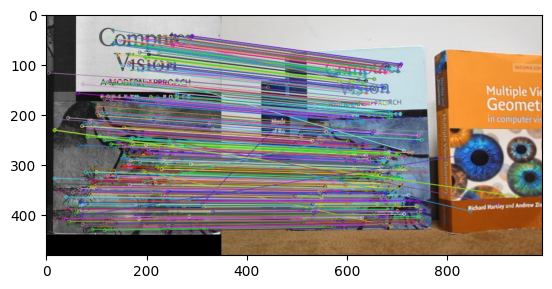

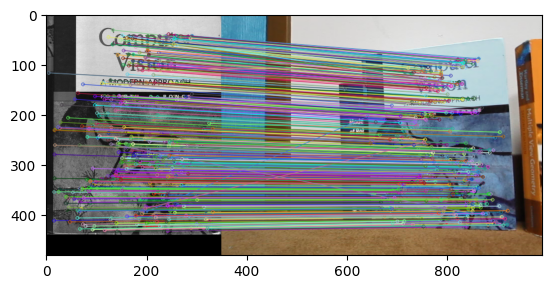

In [174]:
# plot matches for every frame (NOT WORKING)
im = plt.imshow(animated_video[200])
plt.show()
im = plt.imshow(animated_video[300])
plt.show()